In [1]:
# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import glob

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation

In [2]:
# load files paths
data_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\CaSR_data\\'
output_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\\'
shapefile_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\Bow_elevation_combined.shp'

# 1. open all swe data files and combine them into a single xarray dataset spatially and temporally

In [3]:
# 

# Step 1: List all SWE files using the correct data_path variable
file_list = sorted(glob.glob(f"{data_path}CaSR_v3.1_P_SWE_LAND_*.nc"))

if not file_list:
    raise FileNotFoundError(f"No files found with pattern {data_path}CaSR_v3.1_P_SWE_LAND_*.nc")

# Step 2: Open and combine them using xarray
ds_combined_swe = xr.open_mfdataset(
    file_list,
    combine='by_coords',  # will automatically align by time and coordinates
    parallel=True,        # if using Dask or want faster loading
    engine='netcdf4'      # or 'h5netcdf' if you're using that backend
)

# Optional: Check dataset structure
print(ds_combined_swe)




<xarray.Dataset> Size: 15GB
Dimensions:               (rlon: 70, rlat: 70, time: 385704)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1979-12-31T13:00:00 ... 2...
    lon                   (rlat, rlon) float32 20kB dask.array<chunksize=(35, 35), meta=np.ndarray>
    lat                   (rlat, rlon) float32 20kB dask.array<chunksize=(35, 35), meta=np.ndarray>
  * rlon                  (rlon) float64 560B -16.5 -16.41 ... -10.38 -10.29
  * rlat                  (rlat) float64 560B -9.45 -9.36 -9.27 ... -3.33 -3.24
Data variables:
    rotated_pole          (rlon, rlat, time) int32 8GB 1 1 1 1 1 1 ... 1 1 1 1 1
    CaSR_v3.1_P_SWE_LAND  (time, rlat, rlon) float32 8GB dask.array<chunksize=(1, 35, 35), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    source:       https://hpfx.collab.science.gc.ca/~scar700/rcas-casr/
    institution:  Environment and Climate Change Canada / Environnement et Ch...
    title:        Canadian Surface Reanalysis (CaSR) / Réanalyse 

In [5]:
# Print time range
print("Start date:", ds_combined_swe.time.values[0])
print("End date:", ds_combined_swe.time.values[-1])
print("Total time steps:", len(ds_combined_swe.time))#

Start date: 1979-12-31T13:00:00.000000000
End date: 2023-12-31T12:00:00.000000000
Total time steps: 385704


In [6]:
# Extract lon/lat arrays and flatten them
lons = ds_combined_swe['lon'].values.flatten()
lats = ds_combined_swe['lat'].values.flatten()

# Create a DataFrame with lon/lat
df_points = pd.DataFrame({'lon': lons, 'lat': lats})

# Convert longitude to -180 to 180 format for plotting
df_points['lon'] = ((df_points['lon'] + 180) % 360) - 180

# Generate a GeoDataFrame
gdf_swe = gpd.GeoDataFrame(df_points, geometry=gpd.points_from_xy(df_points['lon'], df_points['lat']))
gdf_swe.set_crs(epsg=4326, inplace=True)

display(gdf_swe.head())


,lon,lat,geometry
0,-116.125977,45.872429,POINT (-116.12598 45.87243)
1,-116.006287,45.903149,POINT (-116.00629 45.90315)
2,-115.886475,45.933716,POINT (-115.88647 45.93372)
3,-115.766510,45.964134,POINT (-115.76651 45.96413)
4,-115.646423,45.994408,POINT (-115.64642 45.99441)


In [7]:

# Read the shapefile using geopandas
bow_elevation = gpd.read_file(shapefile_path)
# Set CRS if not already set (assume WGS84)
if bow_elevation.crs is None:
	bow_elevation.set_crs(epsg=4326, inplace=True)
# Ensure the CRS of the GeoDataFrame matches the gdf_swe
bow_elevation = bow_elevation.to_crs(gdf_swe.crs)
# Display the first few rows of the GeoDataFrame
display(bow_elevation.head())

,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."


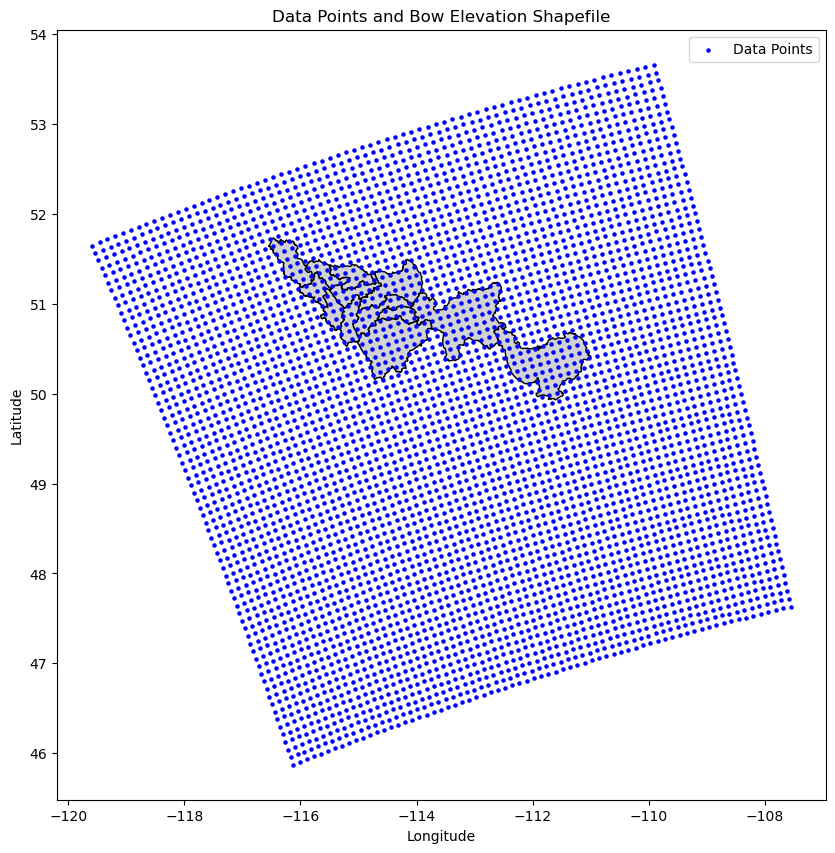

In [8]:
# plot data points and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf_swe.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.set_title('Data Points and Bow Elevation Shapefile')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [9]:
# Create a mask for the original SWE grid using only the points inside the basin
# gdf_bow_swe contains only the points inside the basin

# Make sure to run the cell that creates gdf_bow_swe (cell 9) before running this cell.

# Create a boolean mask for each (rlat, rlon) point: True if in basin, else False
# First, get all lon/lat pairs from ds_combined_swe
lon_grid = ds_combined_swe['lon'].values
lat_grid = ds_combined_swe['lat'].values

# Flatten for easier comparison
lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# Create a set of (lon, lat) tuples for points inside the basin
bow_points_set = set(zip(gdf_swe['lon'], gdf_swe['lat']))

# Build mask: True if (lon, lat) in bow_points_set
mask_flat = np.array([(lon, lat) in bow_points_set for lon, lat in zip(lon_flat, lat_flat)])
mask = mask_flat.reshape(lon_grid.shape)

# Convert to xarray DataArray
mask_xr = xr.DataArray(
	mask,
	dims=("rlat", "rlon"),
	coords={"rlat": ds_combined_swe.rlat, "rlon": ds_combined_swe.rlon}
)

# Extract only the SWE data points inside the basin
ds_bow_swe = ds_combined_swe.where(mask_xr, drop=True)

# Save to NetCDF
ds_bow_swe.to_netcdf(output_path + 'bow_swe.nc')

In [14]:
display(ds_bow_swe)

<xarray.Dataset> Size: 3MB
Dimensions:               (rlon: 0, rlat: 0, time: 385704)
Coordinates:
  * time                  (time) datetime64[ns] 3MB 1979-12-31T13:00:00 ... 2...
    lon                   (rlat, rlon) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
    lat                   (rlat, rlon) float32 0B dask.array<chunksize=(0, 0), meta=np.ndarray>
  * rlon                  (rlon) float64 0B 
  * rlat                  (rlat) float64 0B 
Data variables:
    rotated_pole          (rlon, rlat, time) float64 0B 
    CaSR_v3.1_P_SWE_LAND  (time, rlat, rlon) float32 0B dask.array<chunksize=(1, 0, 0), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    source:       https://hpfx.collab.science.gc.ca/~scar700/rcas-casr/
    institution:  Environment and Climate Change Canada / Environnement et Ch...
    title:        Canadian Surface Reanalysis (CaSR) / Réanalyse Canadienne d...
    contact:      rcas-casr@ec.gc.ca
    licence:      These data are produced and provided by the Environment and...

In [15]:
# create geodataframe for the extracted SWE data
gdf_bow_swe = gpd.GeoDataFrame(
    ds_bow_swe.to_dataframe().reset_index(),
    geometry=gpd.points_from_xy(ds_bow_swe['lon'].values.flatten(), ds_bow_swe['lat'].values.flatten())
)
gdf_bow_swe.set_crs(epsg=4326, inplace=True)
# Display the first few rows of the GeoDataFrame
display(gdf_bow_swe.head())

,rlon,rlat,time,rotated_pole,CaSR_v3.1_P_SWE_LAND,lon,lat,geometry


ValueError: aspect must be finite and positive 

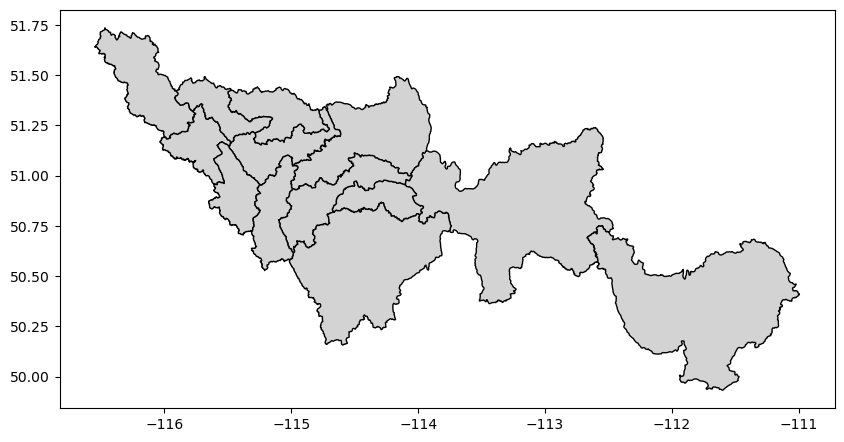

In [11]:
# plot elevation data and SWE data points
fig, ax = plt.subplots(figsize=(10, 10))
bow_elevation.plot(ax=ax, color='lightgrey', edgecolor='black')
# Convert longitude to -180 to 180 format for plotting
gdf_bow_swe_plot = gdf_bow_swe.copy()
gdf_bow_swe_plot['lon'] = ((gdf_bow_swe_plot['lon'] + 180) % 360) - 180
gdf_bow_swe_plot['geometry'] = gpd.points_from_xy(gdf_bow_swe_plot['lon'], gdf_bow_swe_plot['lat'])
gdf_bow_swe_plot.plot(ax=ax, color='blue', markersize=5, label='Bow SWE Points')
ax.set_title('Bow Basin SWE Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()


# 2. open all precipitation data files and combine them into a single xarray dataset spatially and temporally
